# Constants

In [2]:
DATASET_PATH = '../data/dataset_final.csv'

# Imports

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv(DATASET_PATH, header=None)
df.shape

(58302, 1)

# Distribution

In [16]:
code_counts = df[0].apply(lambda x: len(str(x).split(",")))

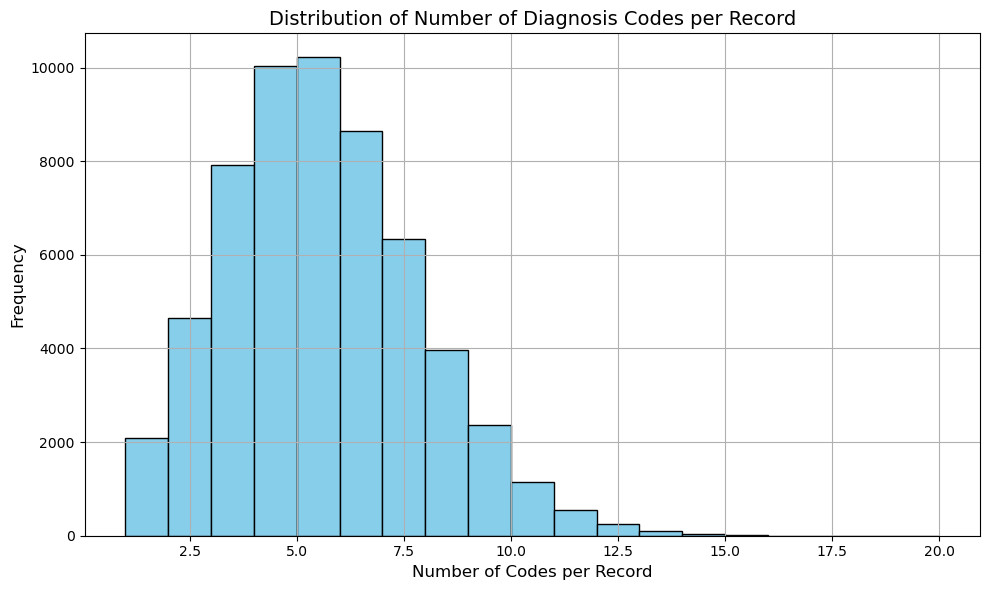

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(code_counts, bins=range(1, max(code_counts)+2), edgecolor='black', color='skyblue')
plt.title("Distribution of Number of Diagnosis Codes per Record", fontsize=14)
plt.xlabel("Number of Codes per Record", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

This histogram shows the distribution of the number of diagnosis codes per patient record in the synthetic dataset. The x-axis represents how many codes appear in a single record (e.g., 5 means that record has 5 diagnosis codes). The y-axis represents the number of records that contain that specific count of codes — i.e., the frequency.

For example:
- At x = 5, the bar height tells us that just over 10,000 records have exactly 5 diagnosis codes.
- At x = 1, about 2,000 records have only 1 code.

Very few records have more than 15 codes — matching the expected right-skewed shape of a Poisson-like distribution.